Set up environment
----

In [2]:
import os
import sys
import itertools
import json

import numpy as np

import matplotlib
#matplotlib.use('Agg')
print (matplotlib.__version__)
%matplotlib notebook
import matplotlib.pyplot as plt

import pyemma
print (pyemma.__version__)
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from msmtools.generation import generate_trajs

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pyemma.config.show_progress_bars = False

1.5.3
2.2.6


User defined
----

In [3]:
debug = True

# user-defined parameters must be checked for each simulation!
#user = json.loads(sys.argv[1])
user = {}
user['adsorbate'] = 'sarin'
user['Nmolec'] = 10
user['T'] = 298
user['fs_per_timestep'] = 1
user['Nframes_requested'] = 'all'
user['region'] = 'micro'
user['clusters'] = {'micro': 128, 'meso': 256}
user['lagtime'] = 800
user['tiles'] = 2
user['CK_nsets'] = 4
user['surrogates'] = 200
user['MCMC_ns'] = 100000

# crystal parameters for NU-1000
crystal = {}
crystal['a'] = 39.97
crystal['b'] = 40.00
crystal['c'] = 16.58*2
crystal['alpha'] = 90
crystal['beta'] = 90
crystal['gamma'] = 120


dumpfile = None
if user['adsorbate']=='sarin':
    dataroot = '/home/vargaslo/ws/fromspurs/sarin_take2/'
    dumpfile = os.path.join(dataroot, str(user['Nmolec']), 'MDSim_298K', '4_my.dump.mod')
    print (dumpfile)
elif user['adsorbate']=='propane':
    user['fs_per_timestep'] = 0.5
    dataroot = '/home/vargaslo/ws/LAMMPS_MD/Alkanes/' + user['adsorbate']
    dumpfile = os.path.join(dataroot, str(user['Nmolec']), 'MDSim_298K', 'lammps_3_extend.dump')
    print (dumpfile)
else:
    print ('MANUALLY INPUT DIRECTORIES')

/home/vargaslo/ws/fromspurs/sarin_take2/10/MDSim_298K/4_my.dump.mod


Useful functions
----

In [4]:
def cosd(deg):
    return np.cos(deg/180. * np.pi)

def sind(deg):
    return np.sin(deg/180. * np.pi)

def xyz2fracM(crystal_prms):
    a = crystal_prms['a']
    b = crystal_prms['b']
    c = crystal_prms['c']
    alpha = crystal_prms['alpha']
    beta = crystal_prms['beta']
    gamma = crystal_prms['gamma']
    v = np.sqrt(1-cosd(alpha)**2-cosd(beta)**2-cosd(gamma)**2 + 2*cosd(alpha)* cosd(beta)*cosd(gamma))
    r1 = [1./a, -cosd(gamma)/a/sind(gamma), (cosd(alpha)*cosd(gamma)-cosd(beta)) / a/v/sind(gamma)]
    r2 = [0, 1./b/sind(gamma), (cosd(beta)*cosd(gamma)-cosd(alpha)) / b/v/sind(gamma)]
    r3 = [0, 0, sind(gamma)/c/v]
    M = np.array([r1, r2, r3])
    return M

def frac2xyzM(crystal_prms):
    a = crystal_prms['a']
    b = crystal_prms['b']
    c = crystal_prms['c']
    alpha = crystal_prms['alpha']
    beta = crystal_prms['beta']
    gamma = crystal_prms['gamma']
    v = np.sqrt(1-cosd(alpha)**2-cosd(beta)**2-cosd(gamma)**2 + 2*cosd(alpha)* cosd(beta)*cosd(gamma))
    r1 = [a, b*cosd(gamma), c*cosd(beta)]
    r2 = [0, b*sind(gamma), c*(cosd(alpha)-cosd(beta)*cosd(gamma))/sind(gamma)]
    r3 = [0, 0, c*v/sind(gamma)]
    M = np.array([r1, r2, r3])
    return M

def wrap(x, y, z, Mfwd, Mrev):
    fxyz = np.dot(Mfwd, np.array([x, y, z]))
    fxyz_ = fxyz % 1
    wrapped = np.dot(Mrev, np.array(fxyz_))
    wrapped = np.around(wrapped, 8)
    return wrapped 


# # Function to read the dump file


def read_file(infiles, frames, ps_per_timestep):
    t = []
    xyz = []
    for infile in infiles:
        with open(infile, 'r') as fin:
            for line in fin:
                line_chunks = line.split()
                if line_chunks[0] != '#':
                    try:
                        ind, x, y, z = map(float, line_chunks)
                        ind = int(line_chunks[0])
                        xyz.append([x, y, z])
                    except:
                        simtimestep, N = map(int, line_chunks)
                        t.append(float(simtimestep))
                if isinstance(frames, (int, float)) and len(t)>frames:
                    break  # do only partial read of file


    # Get number of frames and reshape data array
    numframes =  len(xyz) // N
    xyz = np.reshape(xyz[0:numframes*N], (numframes, N, 3))

    # Convert timestep to ps
    timesteps_per_frame =  int(t[1] - t[0])
    t = (np.array(t[0:numframes]) - t[0]) * ps_per_timestep

    out = {}
    out['xyz'] = xyz
    out['numframes'] = numframes
    out['mlc'] = N
    out['t_ps'] = t
    out['timesteps_per_frame'] = timesteps_per_frame
    
    print ('Number of frames read from file: {}'.format(numframes))
    
    if debug:
        print ("Finished read_file of {}".format(infiles))
        
    return out




def wrapcoords(alldata, Mfwd, Mrev):
    N, trj, dim = np.shape(alldata)
    alldataT= np.transpose(alldata)
    xyz_wrap_T = np.empty((dim, trj, N))
    for i in range(trj):
        frac_T = np.dot(Mfwd, alldataT[:,i,:])
        
        # wrap unit cell coordinates
        frac_wrap_T = frac_T % 1

        # convert fractional to cartesian coords
        xyz_wrap_T[:, i, :] = np.dot(Mrev, frac_wrap_T)

    xyz_wrap = np.transpose(xyz_wrap_T)
    
    if debug:
        print ("finished wrapcoords")
    return xyz_wrap

Read dumpfile to obtain data
----

In [5]:

# read data file
ps_per_timestep = 1e-3 * user['fs_per_timestep']
data = read_file([dumpfile], user['Nframes_requested'], ps_per_timestep)

ps_per_frame = ps_per_timestep * data['timesteps_per_frame']
ns_per_frame = 1e-3 * ps_per_frame

Nframes = data['numframes']
mydat_u_orig = data['xyz']

# designate path from which to read/write files
activedir = os.path.join('{}_N{}_T{}_ff{}_{}_lag{}'.format(user['adsorbate'], user['Nmolec'], user['T'], Nframes, user['region'], user['lagtime']))
print activedir
if not os.path.exists(activedir):
    os.makedirs(activedir)

Number of frames read from file: 41661
Finished read_file of ['/home/vargaslo/ws/fromspurs/sarin_take2/10/MDSim_298K/4_my.dump.mod']
sarin_N10_T298_ff41661_micro_lag800


In [6]:
class data:
    def __init__(self, origdata, crystal_prms):
        self.origdata = origdata
        self.crystal_prms = crystal_prms

        
    @property
    def Mfwd(self):
        return xyz2fracM(self.crystal_prms)

    @property
    def Mrev(self):
        return frac2xyzM(self.crystal_prms)

    @property
    def Nframes(self):
        return np.shape(self.origdata)[0]

    @property
    def Ntrjs(self):
        return np.shape(self.origdata)[1]

    @property
    def Ndims(self):
        return np.shape(self.origdata)[2]

    
    def unwrapped(self):
        return self.origdata
    
    def wrapped(self):
        return wrapcoords(self.origdata, self.Mfwd, self.Mrev)

    #-------------------------------------------------
    # create list of ndarrays(trjs,dims) using indices
    #-------------------------------------------------

    def get_xyz_region(self, hexregions=1):  # hexregions=1 is to split meso/micro
        xyz = self.unwrapped()
        xyz_wrap = self.wrapped()

        # check if inside circle
        P1 = np.dot(self.Mrev, np.array([0.0, 0.0, 0]))   #   P4------P8-------P3
        P2 = np.dot(self.Mrev, np.array([1.0, 0.0, 0]))   #    \        \        \
        P3 = np.dot(self.Mrev, np.array([1.0, 1.0, 0]))   #     \   uc   \   uc   \
        P4 = np.dot(self.Mrev, np.array([0.0, 1.0, 0]))   #      \        \        \
        P5 = np.dot(self.Mrev, np.array([0.0, 0.5, 0]))   #       P5-------P7------P9
        P6 = np.dot(self.Mrev, np.array([0.5, 0.0, 0]))   #        \        \        \
        P7 = np.dot(self.Mrev, np.array([0.5, 0.5, 0]))   #         \   uc   \   uc   \
        P8 = np.dot(self.Mrev, np.array([0.5, 1.0, 0]))   #          \        \        \
        P9 = np.dot(self.Mrev, np.array([1.0, 0.5, 0]))   #           P1-------P6------P2

        region = np.ones((self.Nframes, self.Ntrjs, 1), dtype=int)  # default to region 1 (micro)
                                                                    # region 2 is meso outer, and so on until hexregions+1

        for i in range(hexregions):
            radius = 17 * np.sqrt(1 - 1.*i/hexregions)
            for P in [P1, P2, P3, P4]:
                s2 = np.sum(np.power(xyz_wrap - P, 2)[:,:,0:2], axis=2)
                region[:,:, 0] +=  (s2 <= radius**2)*1  # regions are numbered increasing to the center of channel

        #combined = np.concatenate((xyz, region, xyz_wrap), axis=2)
        reg1 = region==1
        reg2 = region==2
        
        microxyz_w = xyz_wrap*reg1
        mesoxyz_w = xyz_wrap*reg2
    
        combined = np.concatenate((xyz, region, microxyz_w), axis=2)

        return combined

        
    def group_ind(self):
        xyzdata = self.get_xyz_region()
        indices = {}
        indices[1] = []
        indices[2] = []
            
        first = 0
        last = 0
        for p in range(self.Ntrjs):
            for i,v in enumerate(itertools.groupby(xyzdata[:,p,:], lambda x: x[3])):
                key, group = v
                N = len(list(group))
                last = first + N
                indices[int(key)].append((first, last))
            
                first = last
                
        return indices


    def region_hash(self):
        indices = self.group_ind()
        key = {1: 'micro', 2: 'meso'}  # define what the regions mean; must be consistent with get_xyz_region fn
        hashes = {}
        hashes['micro'] = []
        hashes['meso'] = []
        for k,v in indices.iteritems():
            for i in v:
                hashes[key[k]].append(np.arange(i[0], i[1]).tolist())
        return hashes



    def xy2s(self):
        xyz = self.wrapped()
        # check if inside circle
        P1 = np.dot(self.Mrev, np.array([0.0, 0.0, 0]))   #   P4------P8-------P3
        P2 = np.dot(self.Mrev, np.array([1.0, 0.0, 0]))   #    \        \        \
        P3 = np.dot(self.Mrev, np.array([1.0, 1.0, 0]))   #     \   uc   \   uc   \
        P4 = np.dot(self.Mrev, np.array([0.0, 1.0, 0]))   #      \        \        \
        P5 = np.dot(self.Mrev, np.array([0.0, 0.5, 0]))   #       P5-------P7------P9
        P6 = np.dot(self.Mrev, np.array([0.5, 0.0, 0]))   #        \        \        \
        P7 = np.dot(self.Mrev, np.array([0.5, 0.5, 0]))   #         \   uc   \   uc   \
        P8 = np.dot(self.Mrev, np.array([0.5, 1.0, 0]))   #          \        \        \
        P9 = np.dot(self.Mrev, np.array([1.0, 0.5, 0]))   #           P1-------P6------P2


        s1 = np.sqrt(np.sum((xyz[:,:,0:2]-P1[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s2 = np.sqrt(np.sum((xyz[:,:,0:2]-P2[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s3 = np.sqrt(np.sum((xyz[:,:,0:2]-P3[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s4 = np.sqrt(np.sum((xyz[:,:,0:2]-P4[np.newaxis, np.newaxis, 0:2])**2, axis=2))
        s0 = np.minimum(s1, s2)
        s0 = np.minimum(s0, s3)
        s0 = np.minimum(s0, s4)
        
        # composite
        s_to_axis = np.zeros((self.Nframes, self.Ntrjs, 1))
        s_to_axis[:,:,0] = s0

        return s_to_axis


def tile(orig_u, tiles):
    Nframes, Ntrjs, Ndims = np.shape(orig_u)
    rep = np.tile(orig_u, (1, tiles, 1))
    offsets = np.arange(tiles) * crystal['c']
    offsets = np.repeat(offsets, Ntrjs)
    rep[:,:,2] += offsets    
    return rep


def organize(xyzu):
    
    X = data(xyzu, crystal)

    tiled_crystal = crystal.copy()
    tiled_crystal['c'] *= user['tiles']

    tiled_xyzu = tile(xyzu, user['tiles'])
    tiled_X = data(tiled_xyzu, tiled_crystal)
    
    xyzsZ = np.zeros((Nframes, user['Nmolec'], 5))
    xyzsZ[:,:,0:3] = X.wrapped()
    xyzsZ[:,:,3:4] = X.xy2s()
    xyzsZ[:,:,4:5] = X.unwrapped()[:,:,2:]
    
    tiled_xyzsZ = np.zeros((Nframes, user['tiles']*user['Nmolec'], 5))
    tiled_xyzsZ[:,:,0:3] = tiled_X.wrapped()
    tiled_xyzsZ[:,:,3:4] = tiled_X.xy2s()
    tiled_xyzsZ[:,:,4:5] = tiled_X.unwrapped()[:,:,2:]

    out = {'orig': {}, 'tiled': {}}  # keep orig
    out['orig']['composite'] = np.swapaxes(xyzsZ, 0, 1)  # flip axis to make iteration over molecules easier
    out['orig']['micro'] =  {'data': [], 'hash': X.region_hash()['micro']}
    out['orig']['meso'] =   {'data': [], 'hash': X.region_hash()['meso']}
    out['tiled']['composite'] = np.swapaxes(tiled_xyzsZ, 0, 1)  # flip axis to make iteration over molecules easier
    out['tiled']['micro'] = {'data': [], 'hash': tiled_X.region_hash()['micro']}
    out['tiled']['meso'] =  {'data': [], 'hash': tiled_X.region_hash()['meso']}
    
    for k,v in X.region_hash().iteritems():
        for subtraj in v:
            c, r = np.unravel_index(subtraj, (user['Nmolec'], Nframes))    
            out['orig'][k]['data'].append(xyzsZ[r, c, :])
    
    for k,v in tiled_X.region_hash().iteritems():
        for subtraj in v:
            c, r = np.unravel_index(subtraj, (user['tiles']*user['Nmolec'], Nframes))    
            out['tiled'][k]['data'].append(tiled_xyzsZ[r, c, :])
    
    return out


X = organize(mydat_u_orig)

finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords
finished wrapcoords


Visualize trajectory data
----

<IPython.core.display.Javascript object>


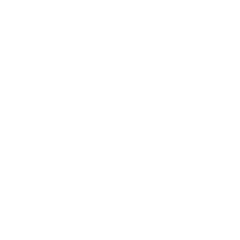

<IPython.core.display.Javascript object>


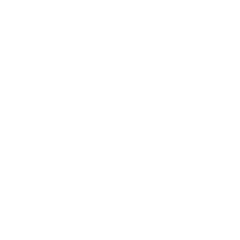

<IPython.core.display.Javascript object>


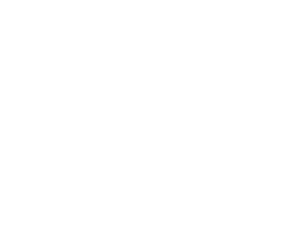

<IPython.core.display.Javascript object>


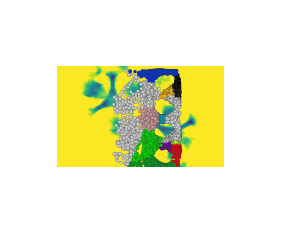

In [32]:
# use this to visualize data

if 1:  # sz dots
    plt.close('all')
    plt.figure(figsize=(3,3))
    plt.gca().set_aspect('equal')

    for i in X['orig']['composite']:
        plt.plot(i[:,3], i[:,2], ls='', marker=',')
        
    plt.axvline(17, c='k', ls='--')
    plt.xlim(0,25)
    plt.ylim(0, 16.58*2)
    plt.xlabel('s component (A)')
    plt.ylabel('z component (A)')
    plt.tight_layout()
    plt.savefig('{}/crds_sz.png'.format(activedir), dpi=144)
    plt.show()
    

if 1:  # xy dots
    plt.close('all')
    plt.figure(figsize=(3,3))
    plt.gca().set_aspect('equal')

    for i in X['orig']['composite']:
        plt.plot(i[:,0], i[:,1], ls='', marker=',')
        
    plt.plot([0, 39.97, 19.97, -20, 0], [0, 0, 34.641, 34.641, 0], c='k', lw=2)
    plt.xlim(-20, 40)
    plt.ylim(0, 34.641)
    plt.xlabel('x component (A)')
    plt.ylabel('y component (A)')
    plt.tight_layout()
    plt.savefig('{}/crds_xy.png'.format(activedir), dpi=144)
    plt.show()


if 1:
    plt.close('all')
    plt.figure(figsize=(3.7,3))
    tmp = np.array([item for sublist in X['orig']['composite'] for item in sublist])
    pyemma.plots.plot_free_energy(tmp[:,3], tmp[:,2], cmap='viridis', cbar=True)
    plt.gca().set_aspect('equal')
    plt.xlabel('s component (A)')
    plt.ylabel('z component (A)')
    plt.xlim(0,25)
    plt.ylim(0, 16.58*2)
    plt.tight_layout()
    plt.savefig('{}/freeE_sz.png'.format(activedir), dpi=144)

    
if 1:
    plt.close('all')
    plt.figure(figsize=(3.7,3))
    tmp = np.array([item for sublist in X['orig']['composite'] for item in sublist])
    pyemma.plots.plot_free_energy(tmp[:,0], tmp[:,1], cmap='viridis', cbar=True)
    plt.gca().set_aspect('equal')
    plt.xlabel('x component (A)')
    plt.ylabel('y component (A)')
    plt.ylim(0,35)
    plt.plot([0, 39.97, 19.97, -20, 0], [0, 0, 34.641, 34.641, 0], c='k', lw=2)
    plt.tight_layout()
    plt.savefig('{}/freeE_xy.png'.format(activedir), dpi=144)


Check lag time against implied timescales

----

In [219]:
def get_maxlag():
    
    lags = [1, 2, 5, 10, 20, 50, 80, 100, 200, 500, 800, 1000, 1500, 2000, 5000]

    out = []
    for lag in lags:
        maxdz = 0
        for subtrj in X['orig'][user['region']]['data']:
            if len(subtrj)>lag:
                zdisp = np.abs(subtrj[lag:, 4] - subtrj[:-lag, 4])
                if np.amax(zdisp) > maxdz:
                    maxdz = np.amax(zdisp)
        if maxdz>0:
            out.append([lag, maxdz])        
    
    for i in out:
        print ('Lag: {0:>5d}  Max z-displacement: {1:5.1f} A'.format(*i))
        
#        for trj in tiled_X.micro_u():
#            if len(trj)>lag:
#                zdisp = np.abs(trj[lag:, 2] - trj[:-lag, 2])
#                if np.amax(zdisp)> maxdz:
#                    maxdz = np.amax(zdisp)
#        maxzdisp.append(maxdz)
#        print ('Lag: {0:>5d}  Max z-displacement: {1:5.1f} A'.format(lag, maxdz))

#    plt.plot(np.array(lags), np.array(maxzdisp))
#    plt.xlabel('Lag frames')
#    plt.ylabel('Max z-disp')
    return 

get_maxlag()

Lag:     1  Max z-displacement:   4.6 A
Lag:     2  Max z-displacement:   6.1 A
Lag:     5  Max z-displacement:   9.5 A
Lag:    10  Max z-displacement:  10.0 A
Lag:    20  Max z-displacement:  12.9 A
Lag:    50  Max z-displacement:  18.7 A
Lag:    80  Max z-displacement:  19.5 A
Lag:   100  Max z-displacement:  20.4 A
Lag:   200  Max z-displacement:  19.4 A
Lag:   500  Max z-displacement:  21.7 A
Lag:   800  Max z-displacement:  19.6 A
Lag:  1000  Max z-displacement:  21.2 A
Lag:  1500  Max z-displacement:  20.9 A
Lag:  2000  Max z-displacement:  21.3 A
Lag:  5000  Max z-displacement:  21.5 A


11-11-16 18:37:47 pyemma.coordinates.clustering.kmeans.KmeansClustering[39] INFO     Cluster centers converged after 15 steps.
[  2   3   5   8  13  20  31  47  72 110 167 255 388 591 899]


<IPython.core.display.Javascript object>


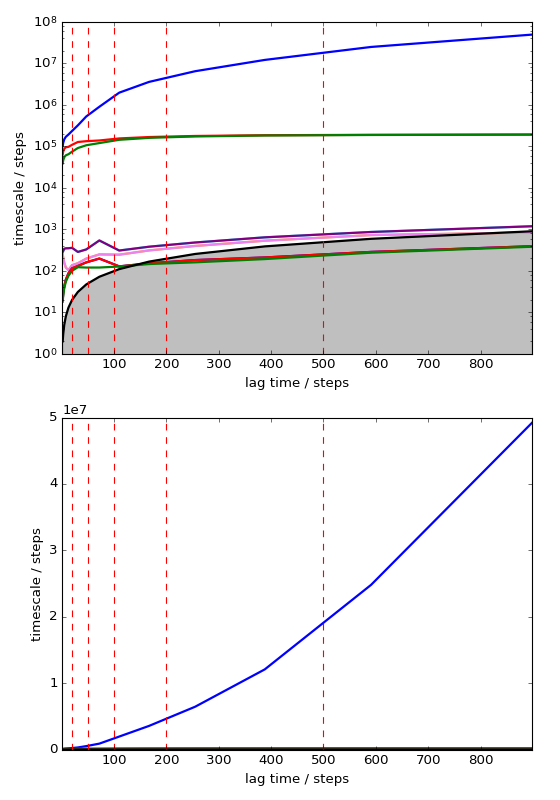

In [220]:
def its_test(n_clusters, Y):
    
    # order is xyzs, so reorder to sz (needed for tiling)
    sz = [i[:,[3,2]] for i in Y['orig'][user['region']]['data']]
    tiled_sz = [i[:,[3,2]] for i in Y['tiled'][user['region']]['data']]

    
    stride = max(1, (Nframes*user['Nmolec'])//100000)
    clustering = coor.cluster_kmeans(data=sz, k=n_clusters, max_iter=200, stride=stride, fixed_seed=True)
 
    # tile the cluster centers
    def tile(cc, tiles):
        Ncc, Ndims = np.shape(cc)
        rep = np.tile(cc, (tiles, 1))
        offsets = np.arange(tiles) * crystal['c']
        offsets = np.repeat(offsets, Ncc)
        rep[:,1] += offsets    
        return rep
    cc = tile(clustering.clustercenters, user['tiles'])

    # use the tiled data
    dtrajs = pyemma.coordinates.assign_to_centers(data=tiled_sz, centers=cc)

    # lag times to use
    maxexponent = np.log10(900)
    exponent = np.linspace(.4, maxexponent, 15)
    lags = np.unique(list(map(int, 10**exponent)))
    print (lags)
    its = msm.timescales_msm(dtrajs, nits=10, lags=lags, n_jobs=-1)
    
    
    plt.figure(figsize=(7,10))
    plt.subplot(211)
    mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)    
    for i in [20, 50, 100, 200, 500]:
        plt.axvline(i, c='r', ls='--')

    plt.subplot(212)
    mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2)
    for i in [20, 50, 100, 200, 500]:
        plt.axvline(i, c='r', ls='--')

        
    plt.tight_layout()

    return n_clusters


plt.close('all')
test = its_test(user['clusters'][user['region']], X)
plt.savefig('{}/its_nclusters{}.png'.format(activedir, test), dpi=144)


Define lag time and discretize trajectories
----

In [34]:
def discretize(X, n_clusters=256, msm_lag=None):
    
    print ('lag time: {}'.format(msm_lag))
    
    # For a defined lag time,
    # Discard shortest trajectories until median trjlength is roughly 4x lag time
    # Discretize trajectories and 

    region = user['region']

    # order is xyzs, so reorder to sz (needed for tiling)
    sz = [i[:,[3,2]] for i in X['orig'][user['region']]['data']]
    tiled_sz = [i[:,[3,2]] for i in X['tiled'][user['region']]['data']]
    
    trajlengths = np.array([len(i) for i in sz])
    for i in range(1,1000):
        minlen = i
        tmp = trajlengths[trajlengths>=minlen]
        if msm_lag <= 1*np.median(tmp):
            medianlen = np.median(tmp)
            meanlen = np.mean(tmp)
            break
    print ('min trjlen:   {:>8}'.format(minlen))
    print ('median trjlen:{:>8.0f}'.format(medianlen))
    print ('mean trjlen:  {:>8.0f}'.format(meanlen))

    
    stride = max(1, (Nframes*user['Nmolec'])//100000)
    print ('stride: {}'.format(stride))


    # get cluster centers using k-means clustering
    tmpY = [i for i in sz if len(i)>=medianlen]  # indices 3,2 are bc we only want s and z components
    clustering = coor.cluster_kmeans(data=tmpY, k=n_clusters, max_iter=200, stride=stride, fixed_seed=True)

    # tile the cluster centers
    def tile(cc, tiles):
        Ncc, Ndims = np.shape(cc)
        rep = np.tile(cc, (tiles, 1))
        offsets = np.arange(tiles) * crystal['c']
        offsets = np.repeat(offsets, Ncc)
        rep[:,1] += offsets    
        return rep
    
    cc = tile(clustering.clustercenters, user['tiles'])
    
    # assign full data set to cluster centers
    dtrajs = pyemma.coordinates.assign_to_centers(data=tiled_sz, centers=cc)


    
    out = {}
    out['dtrajs'] = dtrajs
    out['n_clusters'] = n_clusters
#    out['Y'] = Y
    out['Y'] = tmpY
    out['cc'] = cc
    out['region'] = region
    
    return out

In [32]:
def showdiscretize(X, n_clusters=768, msm_lag=None, dims=None):

    # get cluster centers using k-means clustering
#    tmpY = [i for i in X['orig']['composite'] if len(i)>=medianlen]
#    tmpY_ = [i[dims] for i in X['orig']['composite'] if len(i)>=medianlen]
    tmpY = [i for i in X['orig']['composite']]
    tmpY_ = [i[:,dims] for i in X['orig']['composite']]
    
    stride = max(1, (Nframes*user['Nmolec'])//100000)
    print ('stride: {}'.format(stride))
    clustering = coor.cluster_kmeans(data=tmpY_, k=n_clusters, max_iter=200, stride=stride, fixed_seed=True)
    cc = clustering.clustercenters
    
    # assign full data set to cluster centers
    dtrajs = pyemma.coordinates.assign_to_centers(data=tmpY_, centers=cc)

    out = {}
    out['dtrajs'] = dtrajs
    out['n_clusters'] = n_clusters
    out['Y'] = tmpY
    out['cc'] = cc
    out['region'] = user['region']
    
    return out

stride: 4
12-11-16 01:48:59 pyemma.coordinates.clustering.kmeans.KmeansClustering[62] INFO     Cluster centers converged after 5 steps.


<IPython.core.display.Javascript object>


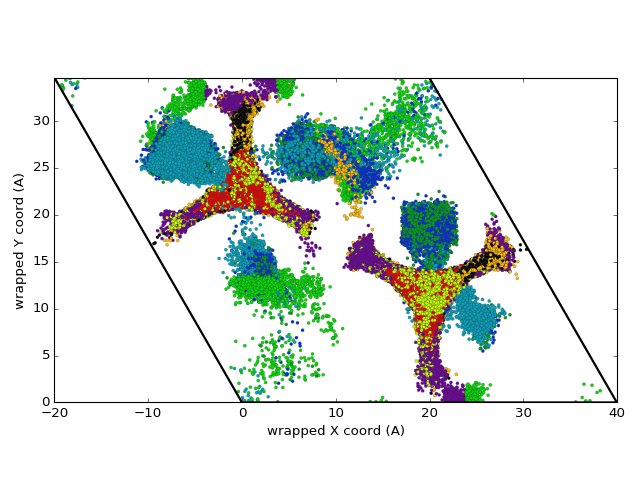

<IPython.core.display.Javascript object>


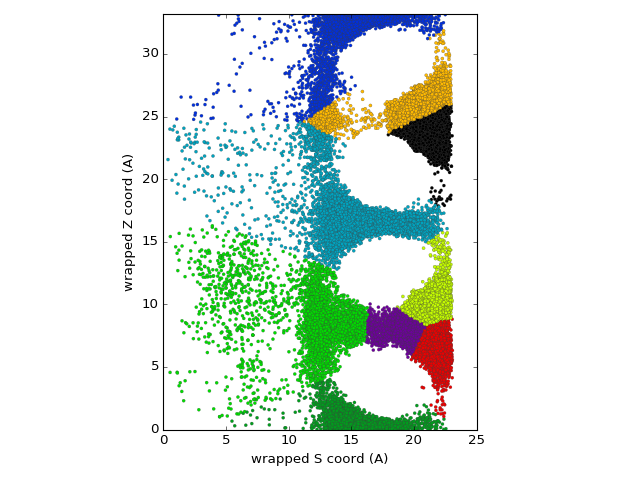

In [46]:
kmeans = showdiscretize(X, n_clusters=9, msm_lag=None, dims=[3,2])  # s,z
#kmeans = showdiscretize(X, n_clusters=9, msm_lag=None, dims=[3])  # s
#kmeans = showdiscretize(X, n_clusters=9, msm_lag=None, dims=[0,1,2])  # x,y,z

plt.close('all')

plt.figure()
for i,c in zip(kmeans['Y'], kmeans['dtrajs']):
    plt.scatter(i[:,0], i[:,1], c=matplotlib.cm.nipy_spectral((255//9)*c), marker='o', s=8, edgecolor='.25', lw=.2)
plt.plot([0, 39.97, 19.97, -20, 0], [0, 0, 34.641, 34.641, 0], c='k', lw=2)
plt.ylim(0, 34.641)
plt.xlim(-20, 40)
plt.gca().set_aspect('equal')
plt.xlabel('wrapped X coord (A)')
plt.ylabel('wrapped Y coord (A)')
plt.tight_layout()

plt.figure()
for i,c in zip(kmeans['Y'], kmeans['dtrajs']):
    plt.scatter(i[:,3], i[:,2], c=matplotlib.cm.nipy_spectral((255//9)*c), marker='o', s=8, edgecolor='.25', lw=.2)
plt.ylim(0, 16.58*2)
plt.xlim(0, 25)
plt.gca().set_aspect('equal')
plt.xlabel('wrapped S coord (A)')
plt.ylabel('wrapped Z coord (A)')
plt.tight_layout()

plt.savefig('{}/xyclusters_top.png'.format(activedir), dpi=144)
plt.show()

MSM
----

In [223]:
def getMSM(n_clusters, lags):
    
#    # kmeans clustering
    
    M = {}
    mylags = lags
    for msm_lag in mylags:
        
        kmeans = discretize(X, n_clusters=n_clusters, msm_lag=msm_lag)
        tmp_M = msm.bayesian_markov_model(kmeans['dtrajs'], msm_lag, nsamples=100)  # default nsamples is 100
        print (tmp_M.active_state_fraction, tmp_M.active_count_fraction)
        
        if tmp_M.active_state_fraction==1 and tmp_M.active_count_fraction==1:
            
            M[msm_lag] = {}
            M[msm_lag]['msm'] = tmp_M
            M[msm_lag]['discretized'] = kmeans
    
    return M


def getCK(MSMs, n_sets):

    for k in sorted(MSMs.keys()):
        
        msm_lag = MSMs[k]['msm'].lag

        maxlength = np.max([len(dtraj) for dtraj in MSMs[k]['msm'].discrete_trajectories_full])
        maxmlag = .4 * maxlength / msm_lag

        mlags = sorted(list(set(np.insert(np.linspace(1, maxmlag, 4, dtype=int),0,0))))
        print (maxlength, maxmlag, mlags)
        
        #print [i*msm_lag*ps_per_frame for i in mlags], 'ps' # ps

        MSMs[k]['ck'] = MSMs[k]['msm'].cktest(n_sets, mlags=mlags)

    return MSMs


M = getMSM(user['clusters'][user['region']]*user['tiles'], [user['lagtime']])

lag time: 800
min trjlen:         30
median trjlen:    1146
mean trjlen:      9685
stride: 4
11-11-16 18:42:29 pyemma.coordinates.clustering.kmeans.KmeansClustering[41] INFO     Cluster centers converged after 4 steps.
(1.0, 1.0)


In [120]:
M_ck = getCK(M, user['CK_nsets'])

NameError: name 'M' is not defined

In [ ]:
plt.close('all')
for k in sorted(M.keys()):
    print ('---------------------------')
    print (k)
    ck = M_ck[k]['ck']
    mplt.plot_cktest(ck, diag=True, y01=True, layout=(1,user['CK_nsets']), padding_between=-.9, padding_top=.8, dt=ns_per_frame, units='ns', figsize=(6,2))
    plt.tight_layout()
    plt.savefig('{}/cktestputput_lag800_nsets12.png'.format(activedir), dpi=144)
    plt.show()


In [224]:
My = M[user['lagtime']]

In [225]:
def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap='viridis', cbar=True, 
                          cbar_label=None, vmin=None, vmax=None):

    # histogram data
    xmin = np.amin(xall)
    xmax = np.amax(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.amin(yall)
    ymax = np.amax(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    #eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = plt.gca()
    cf = ax.contourf(z.T, nlevels, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    if cbar:
        cbar = plt.colorbar(cf)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)
            
    return ax


def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap='viridis', cbar=True, cbar_label=None, vmin=None, vmax=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, 
                                 cbar=cbar, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

Below cell is not quite right.
----

<IPython.core.display.Javascript object>


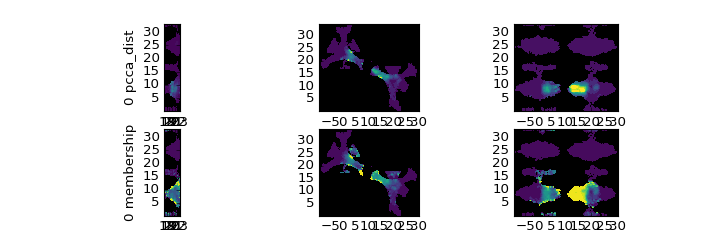

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


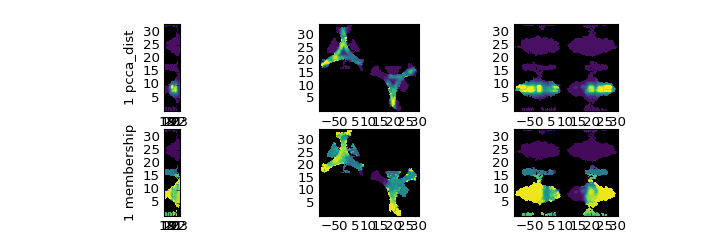

<IPython.core.display.Javascript object>


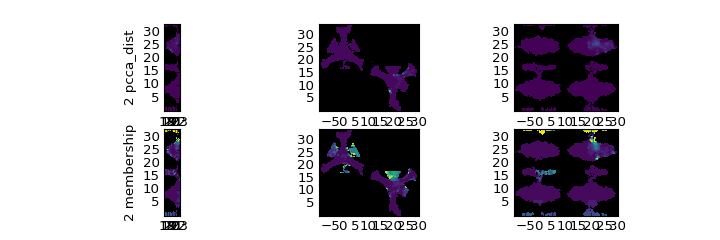

<IPython.core.display.Javascript object>


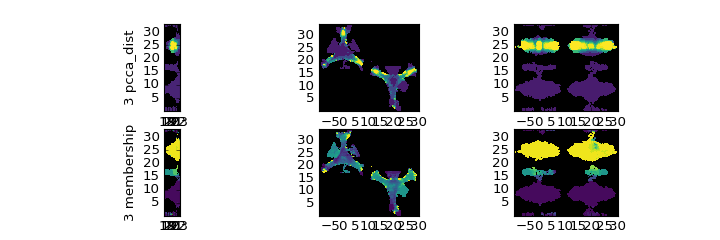

In [238]:
# Number of desired macrostates
My['msm'].pcca(user['CK_nsets'])


pcca_dist = My['msm'].metastable_distributions
membership = My['msm'].metastable_memberships  # get PCCA memberships

# memberships over trajectory
dist_all = [np.hstack([pcca_dist[i,:][dtraj] for dtraj in My['msm'].discrete_trajectories_active]) for i in range(user['CK_nsets'])]
mem_all = [np.hstack([membership[:,i][dtraj] for dtraj in My['msm'].discrete_trajectories_active]) for i in range(user['CK_nsets'])]

def show_pcca_dens(X):


#    indices = X['tiled'][user['region']]['hash']
#    c, r = np.unravel_index(indices, (user['tiles']*user['Nmolec'], Nframes))    
#    xyz_micro = (tiled_X.wrapped()[r, c, 0:3])
#    Y = dat_w_orig

    Y = X['orig'][user['region']]['data']
    flat_Y = np.array([item for sublist in Y for item in sublist])
    
    ncols = 3; nrows = int(np.ceil(user['CK_nsets']*3 / float(ncols)))
#    plt.figure(figsize=(16,nrows*3))
    plt.close('all')
    plt.rc('font', size=12)
    
    
    vmin = 0
    vmax = .01
        
    for i in range(user['CK_nsets']):
        
      #print np.shape(dist_all[i])
      #print np.shape(mem_all[i])
      if 1:
        plt.figure(figsize=(9,3))
        
        # DIST
        plt.subplot(2, ncols, 3*0+1)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(flat_Y[:,3], flat_Y[:,2], (dist_all[i]), cmap='viridis', cbar=False, vmin=vmin, vmax=vmax)
        plt.ylabel('{} pcca_dist'.format(i))
      if 1:
        plt.subplot(2, ncols, 3*0+1+1)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(flat_Y[:,0], flat_Y[:,1], (dist_all[i]), cmap='viridis', cbar=False, vmin=vmin, vmax=vmax)

        plt.subplot(2, ncols, 3*0+1+2)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(flat_Y[:,0], flat_Y[:,2], (dist_all[i]), cmap='viridis', cbar=False, vmin=vmin, vmax=vmax)

        
        # MEMB
        plt.subplot(2, ncols, 3*0+1+3)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(flat_Y[:,3], flat_Y[:,2], (mem_all[i]), cmap='viridis', cbar=False, vmin=0, vmax=1)
        plt.ylabel('{} membership'.format(i))
        
        plt.subplot(2, ncols, 3*0+1+4)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(flat_Y[:,0], flat_Y[:,1], (mem_all[i]), cmap='viridis', cbar=False, vmin=0, vmax=1)

        plt.subplot(2, ncols, 3*0+1+5)
        plt.gca().set_axis_bgcolor('k')
        plt.gca().set_aspect('equal')
        plot_sampled_density(flat_Y[:,0], flat_Y[:,2], (mem_all[i]), cmap='viridis', cbar=False, vmin=0, vmax=1)
      if 1:
        plt.savefig('{}/eig_dens_lag{}_nsets{}_{:02d}.png'.format(activedir, My['msm'].lag, user['CK_nsets'], i), dpi=144)
    return

plt.close('all')

show_pcca_dens(X)


In [239]:
print My['msm'].pcca

<bound method BayesianMSM.pcca of BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=800, nsamples=100, nsteps=22, reversible=True,
      show_progress=True, sparse=False, statdist_constraint=None)>


<IPython.core.display.Javascript object>


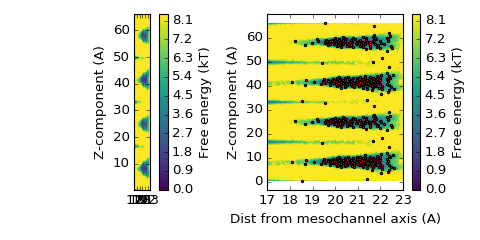

In [243]:
def dtraj_fig(dtrajs):

  Y = X['tiled'][user['region']]['data']
  flat_Y = np.array([item for sublist in Y for item in sublist])

  if 1:    
    plt.figure(figsize=(6,3))
    
    plt.subplot(121)
    pyemma.plots.plot_free_energy(flat_Y[:,3], flat_Y[:,2], cmap='viridis', vmin=0, cbar=True)
    plt.gca().set_aspect('equal')
    #plt.xlabel('Distance from mesochannel axis (A)')
    plt.ylabel('Z-component (A)')
    plt.xlim(17,23)
    #plt.ylim(0,crystal['c'])
    #plt.xticks([17,19,21,23])
    #plt.scatter(clustering.clustercenters[:,0], clustering.clustercenters[:,1], c='r')

  if 1:
    plt.subplot(122)
    pyemma.plots.plot_free_energy(flat_Y[:,3], flat_Y[:,2], cmap='viridis')
    
    cc = My['discretized']['cc']
    plt.scatter(cc[:,0], cc[:,1], c='r', s=4)
    #plt.gca().set_aspect('equal')
    plt.xlabel('Dist from mesochannel axis (A)')
    plt.ylabel('Z-component (A)')
    plt.xlim(17,23)
    #plt.ylim(0,crystal['c'])
    #plt.xticks([17,19,21,23])

    plt.tight_layout()
#    plt.savefig('{}/dtrj0_{}.png'.format(activedir, n_clusters), dpit=144)

    

    return


dtraj_fig('')


Analyze MSM output
----

['dtrajs', 'Y', 'region', 'cc', 'n_clusters']


<IPython.core.display.Javascript object>


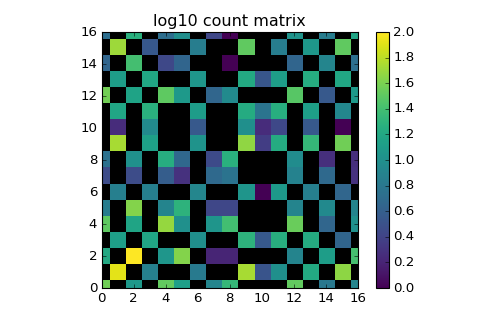

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


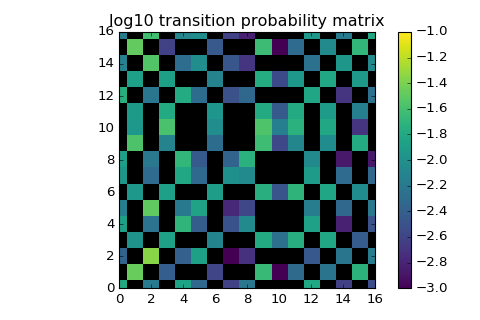

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


In [244]:
def show_trans_mat(M):
        
    plt.figure(figsize=(6,4))
    
    plt.subplot(111)
    plt.imshow(np.log10(M['msm'].count_matrix_active), cmap='viridis', vmin=0, vmax=2, interpolation='nearest')
    plt.gca().set_axis_bgcolor('k')
    plt.colorbar()
    plt.xlim(0,16)
    plt.ylim(0,16)
    plt.title('log10 count matrix')
    plt.savefig('{}/countmatrix_clusters{}_lag{}.png'.format(activedir, My['discretized']['n_clusters'], My['msm'].lag), dpi=144)

    plt.figure(figsize=(6,4))
    plt.subplot(111)
    plt.imshow(np.log10(M['msm'].transition_matrix), cmap='viridis', vmin=-3, vmax=-1, interpolation='nearest')
    plt.gca().set_axis_bgcolor('k')
    plt.colorbar()
    plt.xlim(0,16)
    plt.ylim(0,16)
    plt.title('log10 transition probability matrix')

    plt.tight_layout()
    plt.savefig('{}/TPmatrix_clusters{}_lag{}.png'.format(activedir, My['discretized']['n_clusters'], My['msm'].lag), dpi=144)

    return

print My['discretized'].keys()
plt.close('all')
show_trans_mat(My)


Spectral analysis
=====

View eigenvectors
----

['dtrajs', 'Y', 'region', 'cc', 'n_clusters']
((709758, 2), (709758,))


<IPython.core.display.Javascript object>


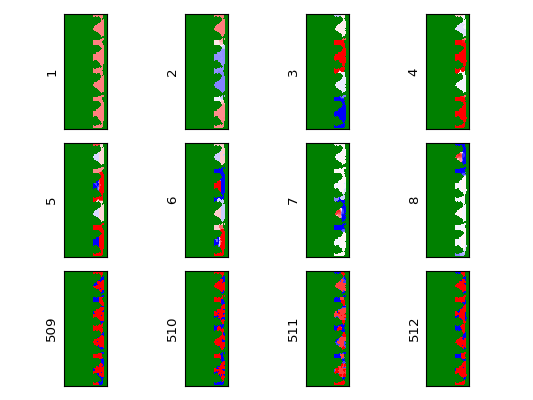

/home/vargaslo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide


In [248]:
def show_eigenvec(Mdict):
    
    M = Mdict['msm']
    dtrajs = Mdict['discretized']['dtrajs']
    print (Mdict['discretized'].keys())
    n_clusters = Mdict['discretized']['n_clusters']*user['tiles']
    
    Y = X['tiled'][user['region']]['data']
    xy = np.array([item for sublist in Y for item in sublist])[:,[3,2]]

#    xy = np.vstack(X['tiled'][user['region']]['data'])
    flat_dtrajs = [j for i in dtrajs for j in i]
    print (np.shape(xy), np.shape(flat_dtrajs))

    plt.figure(figsize=((20./3), 5.))  # w,h ... slide size is x,5
    for ii,i in enumerate([0,1,2,3,4,5,6,7,n_clusters-4, n_clusters-3,n_clusters-2,n_clusters-1]):
        eigval = M.eigenvalues()[i]
        eigvec = M.eigenvectors_right()[:,i]
        
        z = eigvec[flat_dtrajs]

        vmin=-2
        vmax=2
        plt.subplot(3, 4, ii+1)
        plot_sampled_function(xy[:,0], xy[:,1], z, cbar=False, cmap='bwr', vmin=vmin, vmax=vmax, nlevels=50)
        plt.gca().set_aspect('equal')
        plt.gca().set_axis_bgcolor('g')
        plt.xlim(0,25)
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(i+1)
        
    plt.tight_layout()
    plt.savefig('{}/eigenvec_lag{}.png'.format(activedir, My['msm'].lag), dpi=144)

    return

plt.close('all')
show_eigenvec(My)

View eigenvalues
----

<IPython.core.display.Javascript object>


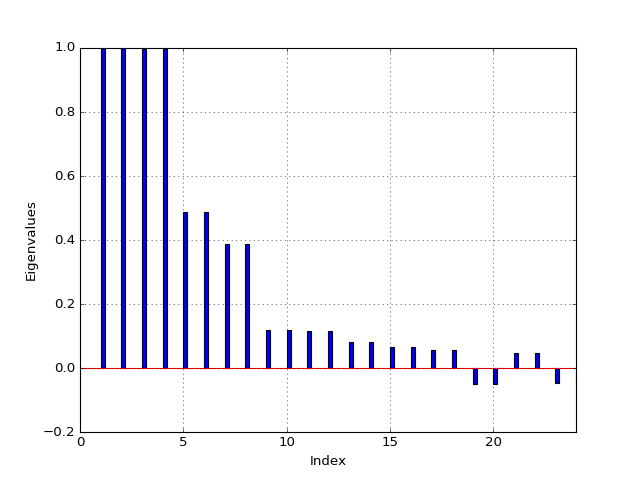

In [249]:
plt.close('all')

plt.figure()
tmpy = My['msm'].eigenvalues()
tmpx = range(1, 1+len(tmpy))
plt.bar(tmpx, tmpy, width=.2)
plt.axhline(0, c='r')
plt.ylabel('Eigenvalues'); 
plt.xlabel('Index'); 
plt.xlim(0,24)
plt.gca().grid(True)

plt.savefig('{}/eigenvalues_clusters{}_lag{}.png'.format(activedir, My['discretized']['n_clusters'], My['msm'].lag), dpi=144)


   i     eigenval          its        ratio
   2       1.0000   37586.7435
------------------------------------- 197.5527
   3       0.9958     190.2619
------------------------------------- 1.0048
   4       0.9958     189.3495
------------------------------------- 170.2263
   5       0.4871       1.1123
------------------------------------- 1.0000
   6       0.4871       1.1123
------------------------------------- 1.3182
   7       0.3875       0.8438
------------------------------------- 1.0001
   8       0.3874       0.8437
------------------------------------- 2.2486
   9       0.1186       0.3752
------------------------------------- 1.0017
  10       0.1181       0.3746
------------------------------------- 1.0094
  11       0.1158       0.3711
------------------------------------- 1.0017
  12       0.1154       0.3705
------------------------------------- 1.1657
  13       0.0807       0.3178
------------------------------------- 1.0000
  14       0.0807       0.3178
---------

<IPython.core.display.Javascript object>


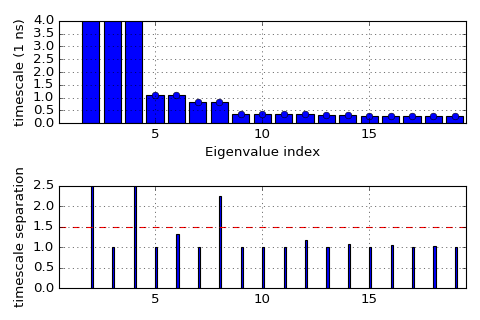

In [299]:
print ('{:>4} {:>12} {:>12} {:>12}'.format('i', 'eigenval', 'its', 'ratio'))
for i in range(18):
    print ('{:4} {:>12.4f} {:>12.4f}'.format(i+2, My['msm'].eigenvalues()[i+1], ns_per_frame*My['msm'].timescales()[i], My['msm'].timescales()[i]/My['msm'].timescales()[i+1]))
    print ('------------------------------------- {:>6.4f}'.format( My['msm'].timescales()[i]/My['msm'].timescales()[i+1]))

    # Show eigenvalue separation
plt.close('all')

plt.figure(figsize=(6,4))
plt.subplot(211)
tmpy = ns_per_frame * My['msm'].timescales()
tmpx = range(2, 2+len(tmpy))
plt.plot(tmpx, tmpy,linewidth=0,marker='o')
plt.bar(np.array(tmpx)-.4, tmpy)
plt.ylabel('timescale (1 ns)'); 
plt.xlabel('Eigenvalue index'); 
plt.xlim(0.5,19.5)
#plt.ylim(0,min(10, plt.ylim()[1]))
plt.ylim(0,4)
plt.gca().grid(True)


if 1:
  plt.subplot(212)
  tmpy_ = My['msm'].timescales()[:-1]/My['msm'].timescales()[1:]
  tmpx_ = range(2, 2+len(tmpy_))
  plt.bar(tmpx_, tmpy_, width=.1)#, linewidth=0,marker='o')
  plt.axhline(1.5, c='r', ls='--')
  plt.ylabel('timescale separation'); 
  plt.xlim(0.5,19.5)
  plt.ylim(0, 2.5)
  plt.gca().grid(True)

plt.tight_layout()
plt.savefig('{}/eigenval_separation_clusters{}_lag{}.png'.format(activedir, My['discretized']['n_clusters'], My['msm'].lag), dpi=144)

Simulate trajectories from MSM
----

In [286]:
class gentrajs:
    def __init__(self,  Ntrajs, Nframes, transmat,cc, ps_per_frame, msm_lag):
        self.transmat = transmat
        self.Ntrajs = Ntrajs
        self.Nframes = Nframes
        self.cc = cc
        self.dtrajs = generate_trajs(self.transmat, self.Ntrajs, self.Nframes)
        self.ps_per_frame = ps_per_frame
        self.msm_lag = msm_lag
        
    def t_ps(self):
        time_ps = np.arange(self.Nframes) * self.ps_per_frame * self.msm_lag
        return time_ps
    
    
    def wrapped(self):
        dtrajs_z = self.cc[self.dtrajs, 1]
        return  dtrajs_z
    
    def unwrapped(self, msm_lag, dt, crystal_c):
               
        allz = []
        dtrajs = self.dtrajs
        for dtraj in dtrajs:
            
            # tmp z coords and dz
            dtraj_z = self.cc[dtraj, 1]
            dz = np.diff(dtraj_z)
            
            # possible periodic images +-pm
            pm = 1
            dz_list = np.tile(dz, (2*pm+1, 1))
            dz_list += crystal_c * np.arange(-pm, pm+1)[:,np.newaxis]

            dzi = np.argmin(np.abs(dz_list), axis=0)
            dz = dz_list[dzi, np.arange(len(dzi))]

            # convert dz to "unwrapped" z
            dz = np.insert(dz,0,0)
            z = np.cumsum(dz)
            z += dtraj_z[0]

            allz.append(z)
            
        return allz
        
MCMC_length = int(user['MCMC_ns']/ns_per_frame/My['msm'].lag)
gen = gentrajs(user['surrogates'], MCMC_length, My['msm'].transition_matrix, My['discretized']['cc'], ps_per_frame, My['msm'].lag)

Check z displacements
----

<IPython.core.display.Javascript object>


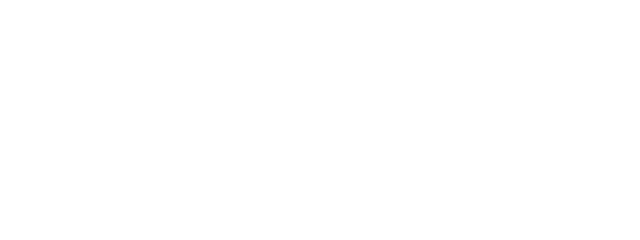

In [287]:
gen_wrapped = gen.wrapped()

plt.figure(figsize=(8,3))

plt.subplot(111)
hdat, bin_edges, _ = plt.hist(np.hstack((np.diff(gen_wrapped, axis=1))), bins=77, color='r', alpha=.1, label='wrapped coords')

plt.gca().set_yscale('log')
plt.ylim(.2, plt.ylim()[1])
plt.xlim(-user['tiles']*crystal['c'], user['tiles']*crystal['c'])
plt.legend(loc='best')
plt.xlabel('z displacement (A) @ {:.1f} ps'.format(My['msm'].lag*ps_per_frame))
plt.ylabel('Histogram counts')
plt.tight_layout()
plt.savefig('{}/histogramcounts_.png'.format(activedir), dpi=144)


Notice that displacements seem to follow exponential distribution with D = 1.8e-9 m2/s.

<IPython.core.display.Javascript object>


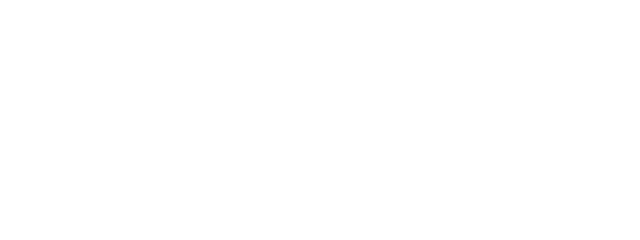

In [288]:
gen_unwrapped = gen.unwrapped(My['msm'].lag, ps_per_frame, user['tiles']*crystal['c'])

plt.figure(figsize=(8,3))

plt.subplot(111)
hdat, bin_edges, _ = plt.hist(np.hstack((np.diff(gen_wrapped, axis=1))), bins=77, color='r', alpha=.1, label='wrapped coords')
plt.hist(np.hstack((np.diff(gen_unwrapped, axis=1))), bins=bin_edges, color='b', alpha=.2, label='unwrapped coords')

#plt.xlim(0, 3*crystal['c'])
plt.gca().set_yscale('log')
plt.ylim(.2, plt.ylim()[1])
plt.xlim(-user['tiles']*crystal['c'], user['tiles']*crystal['c'])

plt.legend(loc='best')
plt.xlabel('z displacement (A) @ {:.1f} ps'.format(My['msm'].lag*ps_per_frame))
plt.ylabel('Histogram counts')



plt.savefig('{}/generated_trjs_distributions.png'.format(activedir), dpi=144)


View z component of trajectories
----

<IPython.core.display.Javascript object>


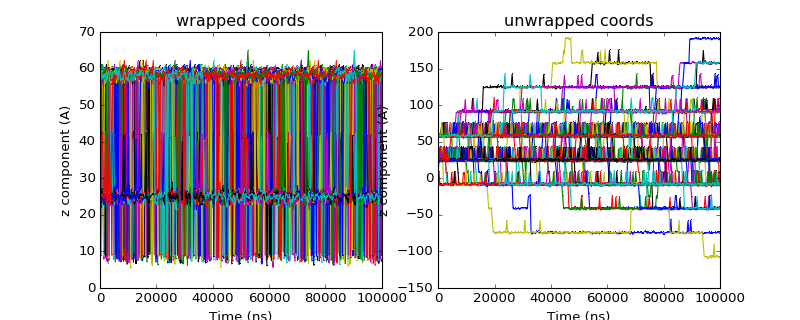

In [301]:
plt.close('all')

plt.figure(figsize=(10,4))

plt.subplot(121)
for i in gen_wrapped:
    plt.plot(.001*gen.t_ps()[::400], i[::400], marker=',')
plt.xlabel('Time (ns)')
plt.ylabel('z component (A)')
plt.title('wrapped coords')

plt.subplot(122)
for i in gen_unwrapped:
    plt.plot(.001*gen.t_ps()[::400], i[::400], marker=',')
plt.xlabel('Time (ns)')
plt.ylabel('z component (A)')
plt.title('unwrapped coords')
    

plt.savefig('{}/simulated_fake_trjs.png'.format(activedir), dpi=144)


Calculate MSD from trajectories
----

In [290]:
def msd(t, z):
    
    Ntrajs, Nframes = np.shape(z)  
    allmsd = np.zeros(Nframes)
    counts = np.zeros(Nframes)


    full = []
    full.extend(xrange(1,      1000, 1))
    full.extend(xrange(1000,   100000, 1000))
    full.extend(xrange(100000, 10000000, 10000))
    full = np.asarray(full)

    for i in range(Ntrajs):
        print i,
        tmp = z[i]        
        jlist = full[full<len(tmp)]

        for j in jlist:
            msd = np.mean((tmp[j:] - tmp[:-j])**2)
            allmsd[j] += msd
            counts[j] += 1

    
    indices = np.nonzero(counts)
    y = allmsd[indices] / counts[indices]
    x = t[indices]
    
#    for i,v in enumerate(allmsd):
#        if counts[i]!=0:
#            allmsd[i] = v/counts[i]
        
#    y = np.trim_zeros(allmsd, trim='b')    
#    x = t

#    return x[1::stride], y[1::stride]
    return x, y

generated_t, generated_msd = msd(gen.t_ps(), gen_unwrapped)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199


Show MSD vs time
----

<IPython.core.display.Javascript object>


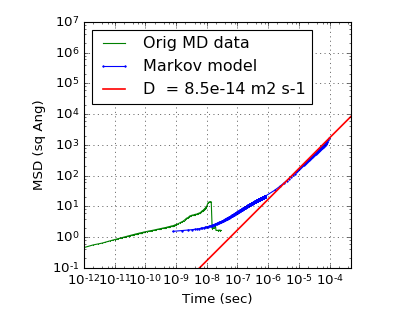

(440800.0, 616800.0)
D  = 8.5e-14 m2 s-1


0

In [291]:
plt.figure(figsize=(5,4))

names = ['ff', 'msdx', 'msdy', 'msdz', 'varx', 'vary', 'varz', 'theta']
msddat = np.genfromtxt('/home/vargaslo/ws/fromspurs/sarin_take2/{}/MDSim_298K/MSD_reg_1_of_2_trjlen99999ps'.format(user['Nmolec']), names=names)
plt.plot(msddat['ff']*ps_per_frame*1e-12, msddat['msdz'], c='g', marker='.', ms=1, label='Orig MD data')

plt.xlim(1e-12, user['MCMC_ns']*1000*5*1e-12)
plt.ylim(.1, 1e7)
plt.gca().set_aspect('equal')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Time (sec)')
plt.ylabel('MSD (sq Ang)')

plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('{}/msd_for_truncated_orig_justdata_lag{}.png'.format(activedir, My['msm'].lag), dpi=144)

#-------------------------------------------------------------

# plot MSD vs t
plt.subplot(111)
plt.plot(generated_t*1e-12, generated_msd, '-', marker='.',  ms=3, markerfacecolor='blue', label='Markov model')

plt.legend(loc='upper left')
plt.savefig('{}/msd_for_truncated_orig_justdata_mcmc_lag{}.png'.format(activedir, My['msm'].lag), dpi=144)

#-------------------------------------------------------------

# line fit to data
tmpind1 = int(.1*len(generated_t))
tmpind2 = int(.25*len(generated_t))
tmpind1 = int(.5*len(generated_t))
tmpind2 = int(.7*len(generated_t))
print (generated_t[tmpind1], generated_t[tmpind2])
tmpx = generated_t[tmpind1:tmpind2]
tmpy = generated_msd[tmpind1:tmpind2]
m, b = np.polyfit(tmpx, tmpy, 1)
print ('D  = {:.1e} m2 s-1'.format(0.5*m*1e-8))
plt.plot([1e-12,1e0], [m*j for j in [1e0,1e12]], c='r', ls='-', lw=1.5, label='D  = {:.1e} m2 s-1'.format(0.5*m*1e-8))
plt.axvline(generated_t[tmpind1])
plt.axvline(generated_t[tmpind2])

# guide lines
for i in [-12, -11]:
    plt.plot([1e0,1e12], [2*10**(i+8)*j for j in [1e0,1e12]], c='k', ls=':')


plt.legend(loc='upper left')
plt.savefig('{}/msd_for_truncated_orig_lag{}.png'.format(activedir, My['msm'].lag), dpi=144)
os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % ( .04,2000))
